In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
from keras.callbacks import *

import tensorflow as tf

from dataset import atti_dirigenti

import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9594625560214775841, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3383230464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11627822429455055404
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## Load the Dataset

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = atti_dirigenti.load_data(num_words=10000, remove_stopwords=True)

In [4]:
label_index = atti_dirigenti.get_labels()
len(label_index)

20

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [5]:
from keras.preprocessing import sequence

In [6]:
print('max length of objects {}'.format(max(map(len, x_train))))

max length of objects 90


#### Maximum Sequence Length

for initial test we use the first 100 words

In [7]:
maxlen = 100

In [8]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_pad = sequence.pad_sequences(x_val, maxlen=maxlen)
x_test_pad = sequence.pad_sequences(x_test, maxlen=maxlen)

In [9]:
x_train_pad.shape

(99390, 100)

One-hot encoding for input

In [10]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float16)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [11]:
dimension = 11000

In [12]:
x_train_vect = vectorize_sequences(x_train, dimension)
x_val_vect = vectorize_sequences(x_val, dimension)
x_test_vect = vectorize_sequences(x_test, dimension)

One hot encoding for the labels

In [13]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [14]:
y_train_vect = to_one_hot(y_train)
y_val_vect = to_one_hot(y_val)
y_test_vect = to_one_hot(y_test)

In [15]:
y_train_vect.shape

(99390, 20)

### Plotting Results Helpers

In [67]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150

%matplotlib inline

In [17]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2, step=0.2))
    plt.xticks(np.arange(0,len(loss), step=1))
    plt.legend()
    plt.show()

In [18]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1, step=0.05))
    plt.xticks(np.arange(0,len(acc), step=1))
    plt.legend()
    plt.show()

In [19]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

## Build the Models

We take into account:
- a base model that uses dropout
- an evaluation of LSTM and GRU models da uses dropout, reverse the text order and uses Bidirectional-LSTM 

In [20]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0)
]

In [22]:
def build_model_dropout(neurons):
    with tf.device('/gpu:0'):
        model = models.Sequential()
        model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train_vect.shape[-1], )))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(len(label_index), activation='softmax'))

        model.compile(optimizer=optimizers.Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
model_dropout = build_model_dropout(256)
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2816256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total para

In [24]:
history_dropout = model_dropout.fit(x=x_train_vect, y=y_train_vect, validation_data=(x_val_vect, y_val_vect),
                   epochs=10, batch_size=256, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 9s 86us/step - loss: 1.2980 - acc: 0.5879 - val_loss: 0.6150 - val_acc: 0.7941
Epoch 2/10
99390/99390 [==============================] - 8s 79us/step - loss: 0.6283 - acc: 0.7901 - val_loss: 0.5252 - val_acc: 0.8198
Epoch 3/10
99390/99390 [==============================] - 8s 78us/step - loss: 0.4923 - acc: 0.8338 - val_loss: 0.4981 - val_acc: 0.8280
Epoch 4/10
99390/99390 [==============================] - 8s 79us/step - loss: 0.4124 - acc: 0.8606 - val_loss: 0.4915 - val_acc: 0.8343
Epoch 5/10
99390/99390 [==============================] - 8s 78us/step - loss: 0.3538 - acc: 0.8797 - val_loss: 0.4968 - val_acc: 0.8389
Epoch 6/10
99390/99390 [==============================] - 8s 78us/step - loss: 0.3133 - acc: 0.8939 - val_loss: 0.4956 - val_acc: 0.8382
Epoch 7/10
99390/99390 [==============================] - 8s 79us/step - loss: 0.2817 - acc: 0.9043 - val_loss: 0.5058 - val_acc

In [25]:
def build_model_cnn(embed_size):
    with tf.device('/gpu:0'):
        model = models.Sequential()
        model.add(layers.Embedding(input_dim=dimension, output_dim=embed_size, input_length=maxlen, name='embed'))
        model.add(layers.Conv1D(16, 5, activation='relu'))
        model.add(layers.MaxPooling1D(5))
        model.add(layers.Conv1D(32, 5, activation='relu'))
        model.add(layers.GRU(64, activation='relu',
                             dropout= 0.5,
                             recurrent_dropout = 0.5,
                             return_sequences=False))
        model.add(layers.Dense(len(label_index), activation='softmax'))

        model.compile(optimizer=optimizers.Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [35]:
model_cnn = build_model_cnn(128)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 100, 128)          1408000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 16)            10256     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 32)            2592      
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1300      
Total params: 1,440,772
Trainable params: 1,440,772
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_cnn = model_cnn.fit(x=x_train_pad, y=y_train_vect,  validation_data=(x_val_pad, y_val_vect),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 10s 105us/step - loss: 1.9925 - acc: 0.3639 - val_loss: 1.1453 - val_acc: 0.6147
Epoch 2/10
99390/99390 [==============================] - 9s 89us/step - loss: 1.0732 - acc: 0.6407 - val_loss: 0.8680 - val_acc: 0.7064
Epoch 3/10
99390/99390 [==============================] - 9s 89us/step - loss: 0.8186 - acc: 0.7220 - val_loss: 0.7757 - val_acc: 0.7368
Epoch 4/10
99390/99390 [==============================] - 9s 89us/step - loss: 0.6693 - acc: 0.7710 - val_loss: 0.7439 - val_acc: 0.7555
Epoch 5/10
99390/99390 [==============================] - 9s 89us/step - loss: 0.5638 - acc: 0.8078 - val_loss: 0.7560 - val_acc: 0.7618
Epoch 6/10
99390/99390 [==============================] - 9s 90us/step - loss: 0.4856 - acc: 0.8344 - val_loss: 0.7604 - val_acc: 0.7696
Epoch 7/10
99390/99390 [==============================] - 9s 89us/step - loss: 0.4193 - acc: 0.8579 - val_loss: 0.7981 - val_a

In [28]:
def build_model_rnn(embed_size, neurons, bidirectional=False, num_layers=1, 
                    dropout=0.5, recurrent_dropout=0.5, cell_type=layers.GRU):
    with tf.device('/gpu:0'):
        model = models.Sequential()
        model.add(layers.Embedding(input_dim=dimension, output_dim=embed_size, input_length=maxlen, name='embed'))

        def create_layer(return_sequences=True):
            layer = cell_type(neurons, activation='relu',
                                     dropout= dropout,
                                     recurrent_dropout = recurrent_dropout,
                                     return_sequences=return_sequences)
            if bidirectional:
                layer = layers.Bidirectional(layer)

            model.add(layers.BatchNormalization())
            return layer

        for l in enumerate(range(num_layers -1)):
            model.add(create_layer())

        model.add(create_layer(return_sequences=False))
        model.add(layers.Dense(len(label_index), activation='softmax'))

        model.compile(optimizer=optimizers.Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
model_gru = model_gru = build_model_rnn(128,256, bidirectional=True)
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 100, 128)          1408000   
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 128)          512       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               591360    
_________________________________________________________________
dense_8 (Dense)              (None, 20)                10260     
Total params: 2,010,132
Trainable params: 2,009,876
Non-trainable params: 256
_________________________________________________________________


In [33]:
history_gru = model_gru.fit(x=x_train_pad, y=y_train_vect,  validation_data=(x_val_pad, y_val_vect),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 111s 1ms/step - loss: 1.2309 - acc: 0.6104 - val_loss: 0.6048 - val_acc: 0.7884
Epoch 2/10
99390/99390 [==============================] - 109s 1ms/step - loss: 0.5746 - acc: 0.8024 - val_loss: 0.5252 - val_acc: 0.8116
Epoch 3/10
99390/99390 [==============================] - 109s 1ms/step - loss: 0.4710 - acc: 0.8347 - val_loss: 0.5103 - val_acc: 0.8245
Epoch 4/10
99390/99390 [==============================] - 110s 1ms/step - loss: 0.4123 - acc: 0.8538 - val_loss: 0.5154 - val_acc: 0.8277
Epoch 5/10
99390/99390 [==============================] - 110s 1ms/step - loss: 0.3745 - acc: 0.8663 - val_loss: 0.5199 - val_acc: 0.8248
Epoch 6/10
99390/99390 [==============================] - 109s 1ms/step - loss: 0.3445 - acc: 0.8764 - val_loss: 0.5369 - val_acc: 0.8309
Epoch 7/10
99390/99390 [==============================] - 109s 1ms/step - loss: 0.3209 - acc: 0.8852 - val_loss: 0.5573 - 

### Printing The Loss

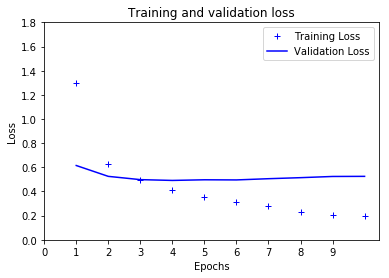

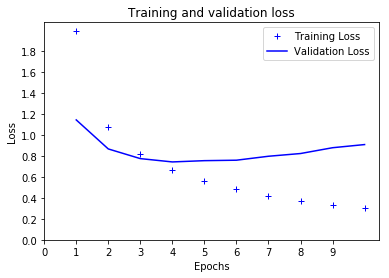

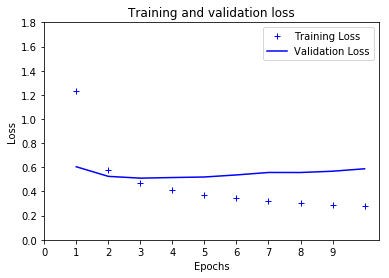

In [68]:
chart_loss(history_dropout)
chart_loss(history_cnn)
chart_loss(history_gru)

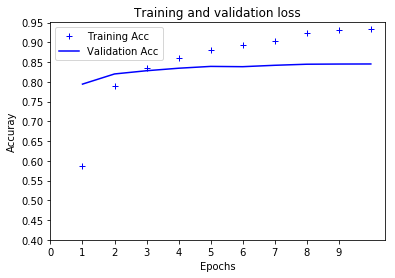

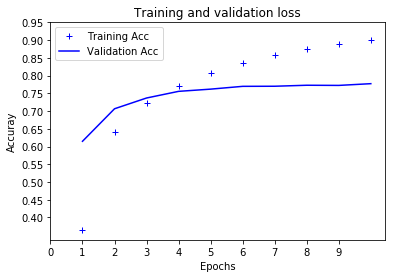

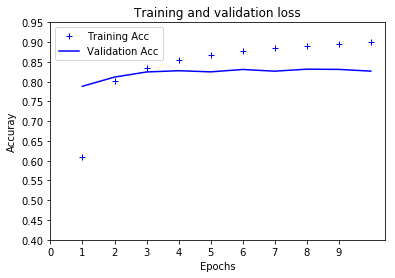

In [44]:
chart_acc(history_dropout)
chart_acc(history_cnn)
chart_acc(history_gru)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [46]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

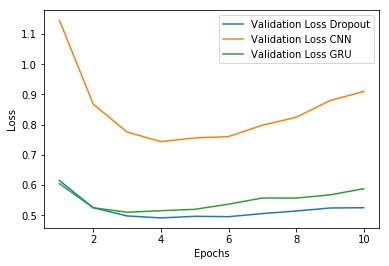

In [48]:
compare_loss({'Dropout': history_dropout, 'CNN': history_cnn, 'GRU': history_gru})

In [50]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

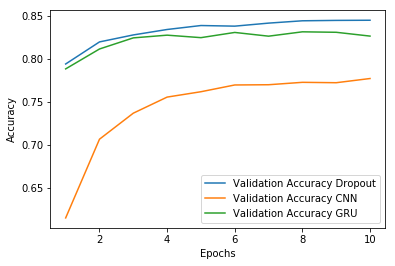

In [51]:
compare_accuracy({'Dropout': history_dropout, 'CNN': history_cnn, 'GRU': history_gru})

In [52]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1 

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch - 1]

In [54]:
print('min loss for model dropout is {}'.format(min_loss(history_dropout)))
print('min loss for model cnn is {}'.format(min_loss(history_cnn)))
print('min loss for model gru is {}'.format(min_loss(history_gru)))

min loss for model dropout is 4
min loss for model cnn is 4
min loss for model gru is 3


In [56]:
print('best validation accuracy for model dropout is {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))
print('best validation accuracy for model cnn is {}'.format(
    accuracy(history_cnn, min_loss(history_cnn))))
print('best validation accuracy for model gru is {}'.format(
    accuracy(history_gru, min_loss(history_gru))))

best validation accuracy for model dropout is 0.834299167054842
best validation accuracy for model cnn is 0.7555233611658145
best validation accuracy for model gru is 0.824520101498884


### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [57]:
model = build_model_rnn(128,256, bidirectional=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 100, 128)          1408000   
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               591360    
_________________________________________________________________
dense_10 (Dense)             (None, 20)                10260     
Total params: 2,010,132
Trainable params: 2,009,876
Non-trainable params: 256
_________________________________________________________________


In [60]:
history = model.fit(x=np.concatenate([x_train_pad, x_val_pad]), y=np.concatenate([y_train_vect, y_val_vect]), 
                    epochs=3, batch_size=256)

Epoch 1/3
110434/110434 [==============================] - 118s 1ms/step - loss: 1.2023 - acc: 0.6210
Epoch 2/3
110434/110434 [==============================] - 117s 1ms/step - loss: 0.5659 - acc: 0.8043
Epoch 3/3
110434/110434 [==============================] - 117s 1ms/step - loss: 0.4669 - acc: 0.8373


In [62]:
loss, acc = model.evaluate(x_test_pad, y_test_vect)

27609/27609 [==============================] - 31s 1ms/step


In [63]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.5066765188834051
acc 0.8221232206997002


## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
